In [204]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.nn import init
import torchvision
from tqdm import tqdm

%matplotlib inline

In [2]:
img_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    lambda x: x.view(-1)
])

# Download and load MNIST dataset
dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=img_transform)

C:\Users\ninja\.conda\envs\ml2\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [252]:
# Function for creating a new transform that permutes `n_permute` pixels
def create_new_permutation(n_input, n_permute):
    old_indices = torch.randperm(n_input)[:n_permute]
    new_indices = old_indices[torch.randperm(n_permute)]
    def new_transform(x):
        if len(x.shape) > 1:
            return torch.stack([new_transform(sample) for sample in x], dim=0)
        x[new_indices] = copy.deepcopy(x)[old_indices]
        return x
    return new_transform

# Reinits weights and biases using the same calculations as PyTorch for linear layers
# Reference: https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/linear.py#L92
def reinit_hidden_units(layer, next_layer, idxs):
    # Reinit weights before the hidden units
    placeholder = torch.empty_like(layer.weight)
    init.kaiming_uniform_(placeholder, a=np.sqrt(5))
    with torch.no_grad():
        layer.weight[idxs] = placeholder[idxs]

    # Reinit weights after the hidden units
    placeholder = torch.empty_like(next_layer.weight)
    init.kaiming_uniform_(placeholder, a=np.sqrt(5))
    with torch.no_grad():
        next_layer.weight[:, idxs] = placeholder[:, idxs]

    # Reinit biases
    placeholder = torch.empty_like(layer.bias)
    fan_in, _ = init._calculate_fan_in_and_fan_out(layer.weight)
    bound = 1 / np.sqrt(fan_in) if fan_in > 0 else 0
    init.uniform_(placeholder, -bound, bound)
    with torch.no_grad():
        layer.bias[idxs] = placeholder[idxs]

In [308]:
class CBPWrapper():
    def __init__(self, model, maturity_thresh=100, replacement_rate=1e-4, decay_rate=0.99):
        self._model = model
        self.maturity_thresh = maturity_thresh # m
        self.replacement_rate = replacement_rate # p
        self.decay_rate = decay_rate # eta

        # One entry per set of weights
        self.layer_weights = [layer.state_dict().get('weight') \
            for layer in self._model.layers \
            if layer.state_dict().get('weight') is not None]
        self.param_layers = [layer for layer in self._model.layers \
            if layer.state_dict().get('weight') is not None]
        
        # One entry per set of hidden units
        self.layer_ages = [torch.zeros(weights.shape[0]) for weights in self.layer_weights[:-1]] # a
        self.layer_avg_vals = [torch.zeros(weights.shape[0]) for weights in self.layer_weights[:-1]] # f
        self.layer_utils = [torch.zeros(weights.shape[0]) for weights in self.layer_weights[:-1]] # u
        self.layer_sizes = np.array([weights.shape[0] for weights in self.layer_weights[:-1]])
        self.replacement_counts = np.zeros(len(self.layer_weights)-1, dtype=np.float32) # How many neurons are pending replacement per layer

    def forward(self, x):
        outputs = self.full_forward(x)
        node_reset = self._cbp_update(outputs)
        return outputs[-1], node_reset

    def full_forward(self, x):
        outputs = [x]
        for layer in self._model.layers:
            x = layer(x)
            if hasattr(layer, 'weight'):
                outputs.append(x)
            else:
                outputs[-1] = x
        return outputs[1:]

    __call__ = forward

    def __getattr__(self, name):
        return getattr(self._model, name)

    def _cbp_update(self, layer_outputs):
        self._increment_weight_ages()
        self._increment_replacement_counts()
        node_reset = False
        for i, output in enumerate(layer_outputs[:-1]):
            weighted_avgs = self.layer_avg_vals[i] / (1 - self.decay_rate ** self.layer_ages[i])
            # Update average hidden outputs (f)
            self.layer_avg_vals[i] = (1 - self.decay_rate) * output.mean(dim=0) + self.decay_rate * self.layer_avg_vals[i]

            weighted_utils = self.layer_utils[i] / (1 - self.decay_rate ** self.layer_ages[i])
            new_util_target = \
                torch.abs(output.mean(dim=0) - weighted_avgs) \
                * self.layer_weights[i+1].T.abs().sum(1) \
                / self.layer_weights[i].T.abs().sum(0)
            self.layer_utils[i] = (1 - self.decay_rate) * new_util_target + self.decay_rate * self.layer_utils[i]

            if self.replacement_counts[i] >= 1:
                ineligible_features_idxs = self.layer_ages[i] < self.maturity_thresh
                weighted_utils[ineligible_features_idxs] = float('inf')
                reset_idxs = torch.topk(weighted_utils, k=int(self.replacement_counts[i]), largest=False)[1]
                # print(f'Resetting units {reset_idxs} of layer {i}')
                reinit_hidden_units(self.param_layers[i], self.param_layers[i+1], reset_idxs)
                self.layer_ages[i][reset_idxs] = 0
                self.layer_avg_vals[i][reset_idxs] = 0
                self.layer_utils[i][reset_idxs] = 0
                self.replacement_counts[i] = 0

                node_reset = True
        return node_reset

    def _increment_weight_ages(self):
        for i in range(len(self.layer_ages)):
            self.layer_ages[i] += 1

    def _increment_replacement_counts(self):
        self.replacement_counts += self.replacement_rate * self.layer_sizes

# Create a simple feed-forward network for MNIST classification
class DenseModel(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.n_hidden = 128
        self.layers = nn.Sequential(
            nn.Linear(n_input, self.n_hidden),
            nn.ReLU(),
            nn.Linear(self.n_hidden, self.n_hidden),
            nn.ReLU(),
            nn.Linear(self.n_hidden, n_output))

    def forward(self, x):
        return self.layers(x)

    def probs(self, x):
        return torch.softmax(self(x), dim=1)

In [309]:
data_dim = 28 * 28
n_classes = 10
batch_size = 16
lr = 0.001

In [313]:
def train_model(model, optimizer, dataloader, train_steps=int(1e5),
                n_permute=0, change_permute_freq=10000):
    criterion = nn.CrossEntropyLoss()
    permute_transform = create_new_permutation(data_dim, n_permute)

    global acc_hist, loss_hist
    acc_hist, loss_hist = [], []
    data_iter = iter(dataloader)
    for step_idx in tqdm(range(1, train_steps // batch_size + 1)):
        try:
            x, y = next(data_iter)
        except StopIteration:
            data_iter = iter(dataloader)
            x, y = next(data_iter)
        x = permute_transform(x)
        
        y = torch.tensor(y)
        output = model(x)
        if isinstance(output, tuple):
            logits, node_reset = output
        else:
            logits = output
            node_reset = False
        pred_y = torch.argmax(logits, dim=1)
        loss = criterion(logits, y)

        if not node_reset:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        loss_hist.append(loss.item())
        acc_hist.append(torch.sum(pred_y == y).item() / len(y))

        if step_idx * batch_size % change_permute_freq == 0:
            permute_transform = create_new_permutation(data_dim, n_permute)

    return acc_hist, loss_hist

# Run basic model training on MNIST

In [315]:
model = DenseModel(data_dim, n_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# Create a simple dataloader for the MNIST dataset that loops on completion
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0)

n_permute = 600
change_permute_freq = 5000 // batch_size * batch_size
train_steps = int(3e5) # int(5e7)
baseline_acc_hist, baseline_loss_hist = train_model(
    model, optimizer, dataloader,
    train_steps = train_steps,
    n_permute = n_permute,
    change_permute_freq = change_permute_freq)

  0%|          | 0/18750 [00:00<?, ?it/s]<ipython-input-313-e9c0607aac07>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)
100%|██████████| 18750/18750 [01:26<00:00, 217.49it/s]


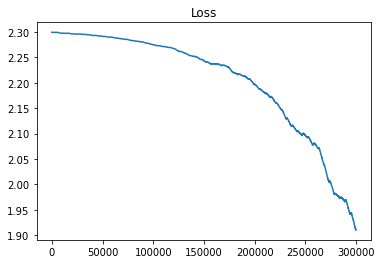

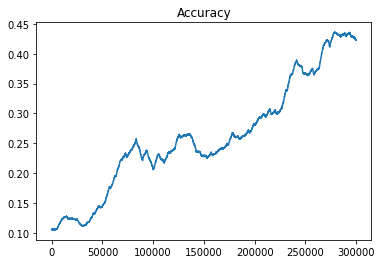

In [319]:
# Plot the moving average of loss and accuracy
# Source: https://stackoverflow.com/questions/14313510/how-to-calculate-rolling-moving-average-using-python-numpy-scipy
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

avg_len = 1000

plt.title('Loss')
ys = moving_average(baseline_loss_hist, avg_len)
xs = np.arange(len(ys)) / len(ys) * len(baseline_loss_hist) * batch_size
plt.plot(xs, ys)
plt.show()

plt.title('Accuracy')
ys = moving_average(baseline_acc_hist, avg_len)
xs = np.arange(len(ys)) / len(ys) * len(baseline_acc_hist) * batch_size
plt.plot(xs, ys)
plt.show()

In [320]:
model = CBPWrapper(DenseModel(data_dim, n_classes))
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# Create a simple dataloader for the MNIST dataset that loops on completion
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0)

n_permute = 600
change_permute_freq = 1000 // batch_size * batch_size
train_steps = int(3e5) # int(5e7)
cbp_acc_hist, cbp_loss_hist = train_model(
    model, optimizer, dataloader,
    train_steps = train_steps,
    n_permute = n_permute,
    change_permute_freq = change_permute_freq)

  0%|          | 0/18750 [00:00<?, ?it/s]<ipython-input-313-e9c0607aac07>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)
 19%|█▊        | 3508/18750 [00:19<01:27, 173.25it/s]

In [ ]:
# Plot the moving average of loss and accuracy
# Source: https://stackoverflow.com/questions/14313510/how-to-calculate-rolling-moving-average-using-python-numpy-scipy
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

avg_len = 1000

plt.title('Loss')
ys = moving_average(cbp_loss_hist, avg_len)
xs = np.arange(len(ys)) / len(ys) * len(cbp_loss_hist) * batch_size
plt.plot(xs, ys)
plt.show()

plt.title('Accuracy')
ys = moving_average(cbp_acc_hist, avg_len)
xs = np.arange(len(ys)) / len(ys) * len(cbp_acc_hist) * batch_size
plt.plot(xs, ys)
plt.show()